# Import library

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
import datetime as dt
import xgboost as xgb
% matplotlib inline
seed = 129

/home/sudhir/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Import Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('sample_submission_zero.csv')
members = pd.read_csv('members.csv',parse_dates=['registration_init_time','expiration_date'])

In [3]:
print('Number of rows  & columns',train.shape)
train.head()

Number of rows  & columns (992931, 2)


,msno,is_churn
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


In [52]:
print('Number of rows  & columns',test.shape)
test.head()

Number of rows  & columns (970960, 19)


,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date,duration,reg_day,reg_weekday,reg_week,reg_month,reg_year,exp_day,exp_weekday,exp_week,exp_month,exp_year
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,0,5.0,28.0,male,3.0,2013-12-23,2017-08-22,1338.0,23.0,0.0,52.0,12.0,2013.0,22.0,1.0,34.0,8.0,2017.0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,0,13.0,20.0,male,3.0,2013-12-23,2017-05-19,1243.0,23.0,0.0,52.0,12.0,2013.0,19.0,4.0,20.0,5.0,2017.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,0,13.0,18.0,male,3.0,2013-12-27,2017-09-19,1362.0,27.0,4.0,52.0,12.0,2013.0,19.0,1.0,38.0,9.0,2017.0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,0,1.0,0.0,NaN,7.0,2014-01-09,2016-03-25,806.0,9.0,3.0,2.0,1.0,2014.0,25.0,4.0,12.0,3.0,2016.0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,0,13.0,35.0,female,7.0,2014-01-25,2018-02-18,1485.0,25.0,5.0,4.0,1.0,2014.0,18.0,6.0,7.0,2.0,2018.0


In [261]:
print('Number of rows  & columns',members.shape)
members.head()

Number of rows  & columns (5116194, 7)


,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,URiXrfYPzHAlk+7+n7BOMl9G+T7g8JmrSnT/BU8GmEo=,1,0,NaN,9,2015-05-25,2015-05-26
1,U1q0qCqK/lDMTD2kN8G9OXMtfuvLCey20OAIPOvXXGQ=,1,0,NaN,4,2016-12-21,2016-12-24
2,W6M2H2kAoN9ahfDYKo3J6tmsJRAeuFc9wl1cau5VL1Q=,1,0,NaN,4,2016-03-06,2016-03-09
3,1qE5+cN7CUyC+KFH6gBZzMWmM1QpIVW6A43BEm98I/w=,5,17,female,4,2016-10-31,2016-11-07
4,SeAnaZPI+tFdAt+r3lZt/B8PgTp7bcG/1os39u4pLxs=,1,0,NaN,4,2017-02-02,2017-02-05


In [74]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5116194 entries, 0 to 5116193
Data columns (total 7 columns):
msno                      object
city                      int64
bd                        int64
gender                    object
registered_via            int64
registration_init_time    datetime64[ns]
expiration_date           datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 273.2+ MB


# Merge data set

In [4]:
train = train.merge(members,on='msno',how='left')
test = test.merge(members,on='msno',how='left')

## Date feature 

In [7]:
def date_feature(df):
    
    col = ['registration_init_time','expiration_date']
    var = ['reg','exp']
    df['duration'] = (df[col[1]] - df[col[0]]).dt.days 
    
    for i ,j in zip(col,var):
        df[j+'_day'] = df[i].dt.day
        df[j+'_weekday'] = df[i].dt.weekday        
        df[j+'_month'] = df[i].dt.month
        df[j+'_year'] =df[i].dt.year

date_feature(train)
date_feature(test)

# Data analysis 

In [8]:
train.columns

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'duration', 'reg_day',
       'reg_weekday', 'reg_month', 'reg_year', 'exp_day', 'exp_weekday',
       'exp_month', 'exp_year'],
      dtype='object')

# Missing value

In [125]:
train.isnull().sum()

msno                           0
is_churn                       0
city                      116788
bd                        116788
gender                    596874
registered_via            116788
registration_init_time    116788
expiration_date           116788
duration                  116788
reg_day                   116788
reg_weekday               116788
reg_week                  116788
reg_month                 116788
reg_year                  116788
exp_day                   116788
exp_weekday               116788
exp_week                  116788
exp_month                 116788
exp_year                  116788
dtype: int64

In [126]:
test.isnull().sum()

msno                           0
is_churn                       0
city                      111272
bd                        111272
gender                    577627
registered_via            111272
registration_init_time    111272
expiration_date           111272
duration                  111272
reg_day                   111272
reg_weekday               111272
reg_week                  111272
reg_month                 111272
reg_year                  111272
exp_day                   111272
exp_weekday               111272
exp_week                  111272
exp_month                 111272
exp_year                  111272
dtype: int64

In [25]:
train[train.isnull().any(axis=1)]

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date,duration,reg_day,reg_weekday,reg_week,reg_month,reg_year,exp_day,exp_weekday,exp_week,exp_month,exp_year
36,ddBEjhJQYsrouP54GTueBgvsQPrd7frM1YDSp6zi8T0=,1,1.0,0.0,NaN,7.0,2010-12-05,2016-01-19,1871.0,5.0,6.0,48.0,12.0,2010.0,19.0,1.0,3.0,1.0,2016.0
38,VfYC7n/QvuWB3UU/SY61iPt9iqC8ltjvQsx3wx8WYXs=,1,1.0,0.0,NaN,7.0,2010-12-15,2017-01-13,2221.0,15.0,2.0,50.0,12.0,2010.0,13.0,4.0,2.0,1.0,2017.0
41,XuPJLX1BsHAKLQLSGfd9yD54EGRBRC6pW3s+RgOh6DI=,1,1.0,0.0,NaN,7.0,2011-04-02,2017-01-12,2112.0,2.0,5.0,13.0,4.0,2011.0,12.0,3.0,2.0,1.0,2017.0
42,jiAxhybwtRs6r2Ddj+4cHYau/AHQpYvTKfHGwXRwej4=,1,1.0,0.0,NaN,7.0,2011-04-19,2017-02-19,2133.0,19.0,1.0,16.0,4.0,2011.0,19.0,6.0,7.0,2.0,2017.0
44,c147tEGAJb25r45hf3QBGOMgDZY4Dj+4r5C55UzCo+Q=,1,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,RDORQtPyKzHL5SareGpQaCEAi90H2QQwQ5zOEx8FZJY=,1,1.0,0.0,NaN,7.0,2011-08-08,2017-02-13,2016.0,8.0,0.0,32.0,8.0,2011.0,13.0,0.0,7.0,2.0,2017.0
52,U+aPFwMoie3QXmtFBCv5awt7BF6twKrCtKWmPXrZn64=,1,13.0,0.0,NaN,9.0,2012-01-03,2017-04-23,1937.0,3.0,1.0,1.0,1.0,2012.0,23.0,6.0,16.0,4.0,2017.0
53,8J5i/i7uRHbVdpHJcF+w6bhN5Sytmq1rTk8/EPGlEQI=,1,1.0,0.0,NaN,7.0,2012-01-07,2017-01-09,1829.0,7.0,5.0,1.0,1.0,2012.0,9.0,0.0,2.0,1.0,2017.0
58,F1MX6AGcEglpcilkVrh9BdtyMqsxdbp1IGlr8Q8FpgM=,1,1.0,0.0,NaN,7.0,2012-05-06,2017-02-17,1748.0,6.0,6.0,18.0,5.0,2012.0,17.0,4.0,7.0,2.0,2017.0
60,Cgn789b2h1Pkqt9pusQlmrCH0hIYFSTPSciAHF0+sAU=,1,14.0,0.0,NaN,9.0,2012-06-09,2018-03-19,2109.0,9.0,5.0,23.0,6.0,2012.0,19.0,0.0,12.0,3.0,2018.0


Here data set contains equal number of Na's. So value for entire row is not present, we can easly remove those rows in data set

In [162]:
pd.isnull(train.any(axis=0))

msno                      False
is_churn                  False
city                      False
bd                        False
gender                    False
registered_via            False
registration_init_time    False
expiration_date           False
duration                  False
reg_day                   False
reg_weekday               False
reg_week                  False
reg_month                 False
reg_year                  False
exp_day                   False
exp_weekday               False
exp_week                  False
exp_month                 False
exp_year                  False
dtype: bool

In [9]:
def missing(df):
    col = df.columns
    for i in col:
        df[i].fillna(df[i].mode()[0],inplace=True)

missing(train)
missing(test)

#train['registration_init_time'].fillna(0,inplace=True)
#test['registration_init_time'].fillna(0,inplace=True)

# is_churn

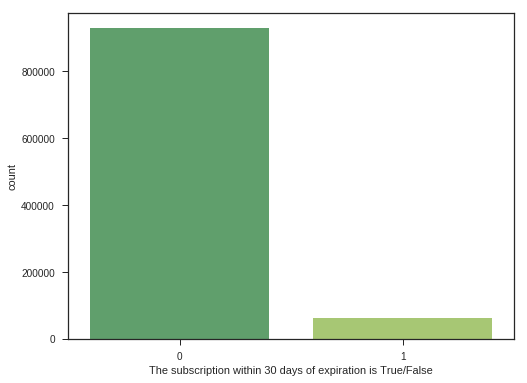

In [7]:
plt.figure(figsize=(8,6))
sns.set_style('ticks')
sns.countplot(train['is_churn'],palette='summer')
plt.xlabel('The subscription within 30 days of expiration is True/False')

is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

Imbalanced data set

msno: user id

is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. 
is_churn = 1 means churn,is_churn = 0 means renewal.

## City

[ 18.  10.  11.  13.   3.   6.   4.  14.  22.  17.   5.   9.   1.  15.  nan
  12.   8.   7.  21.  20.  16.  19.]


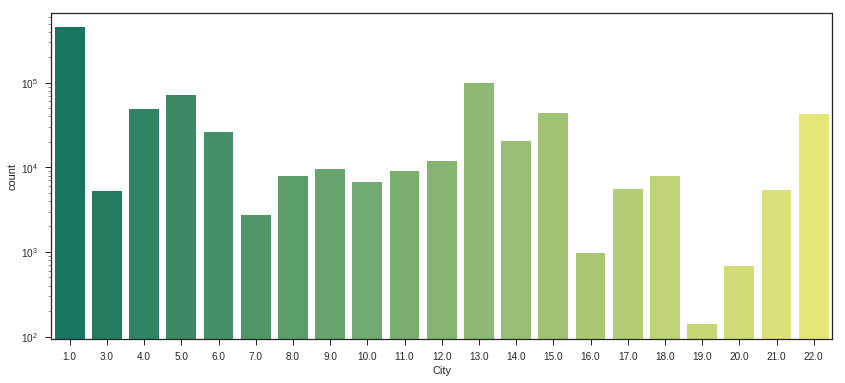

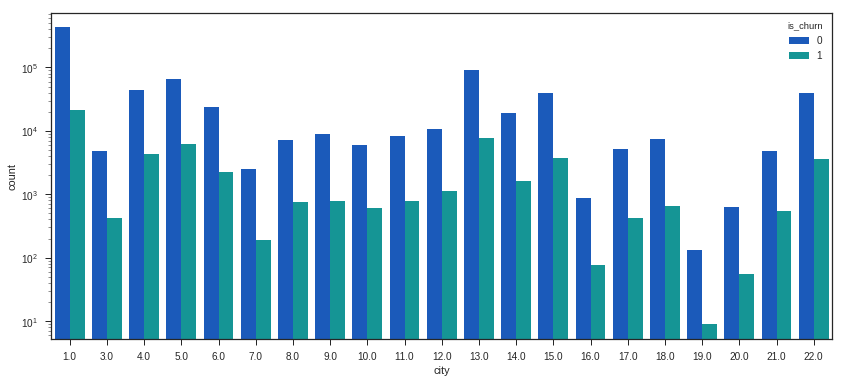

In [37]:
print(train['city'].unique())
plt.figure(figsize=(14,6))
sns.set(style="ticks")
sns.countplot(train['city'],palette='summer')
plt.yscale('log')
plt.xlabel('City')

plt.figure(figsize=(14,6))
sns.set(style="ticks")
sns.countplot(x='city',hue = 'is_churn',data = train,palette='winter')
plt.yscale('log')

# bd  Age

In [58]:
print('Number of Unique value',train['bd'].nunique())
print('\n',train['bd'].head())
print(train['bd'].describe())

Number of Unique value 231

 0    36.0
1    38.0
2    27.0
3    23.0
4    27.0
Name: bd, dtype: float64
count    876143.000000
mean         13.559955
std          20.153530
min       -3152.000000
25%           0.000000
50%           0.000000
75%          27.000000
max        2015.000000
Name: bd, dtype: float64


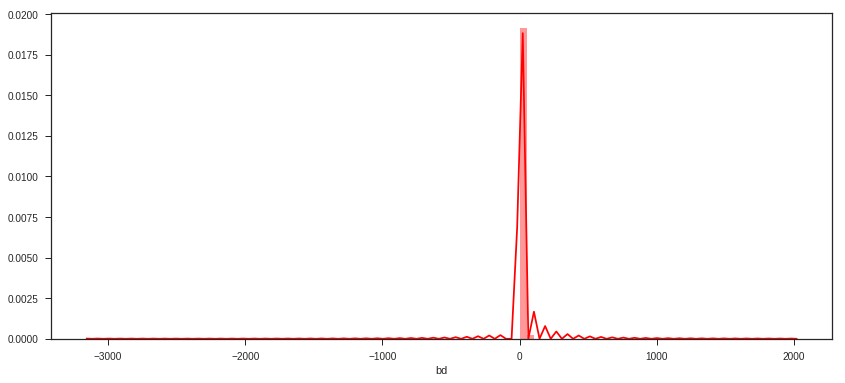

In [8]:
plt.figure(figsize=(14,6))
sns.set_style('ticks')
sns.distplot(train['bd'].fillna(train['bd'].mode()[0]),bins=100,color='r')
#plt.xscale('log')

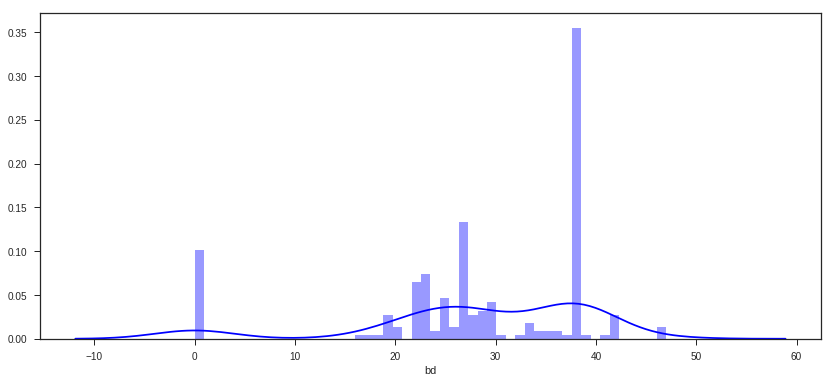

In [7]:
plt.figure(figsize=(14,6))
sns.distplot(train.loc[train['bd'].value_counts()]['bd'].fillna(0),bins=50,color='b')

# Gender

In [8]:
print(pd.crosstab(train['is_churn'],train['gender']))

gender    female    male
is_churn                
0         171705  189875
1          16152   18325


Number of unique value [0 1]


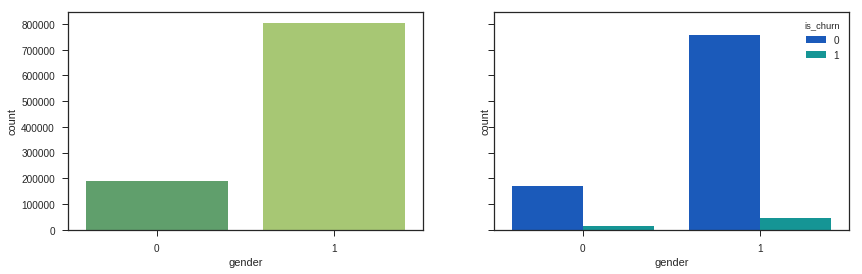

In [89]:
print('Number of unique value',train['gender'].unique())

fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(14,4))

sns.set_style('ticks')
sns.countplot(train['gender'],palette='summer',ax=ax1)

sns.countplot(data=train,x='gender',palette='winter',hue='is_churn',ax=ax2)
#plt.tight_layout


# registered_via

Number of unique value [  9.   7.  nan   3.   4.  13.]


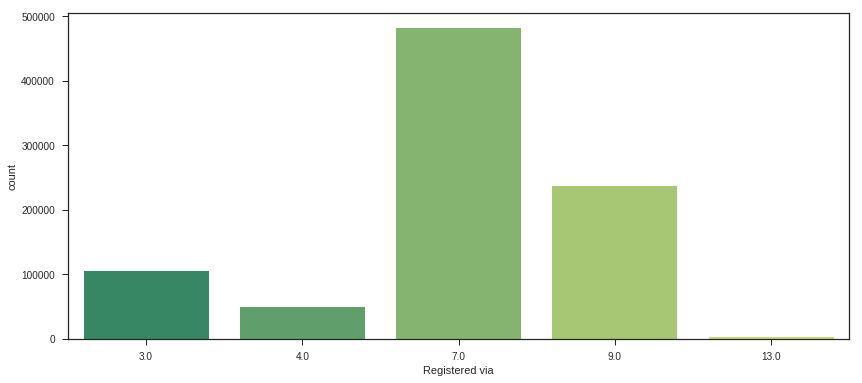

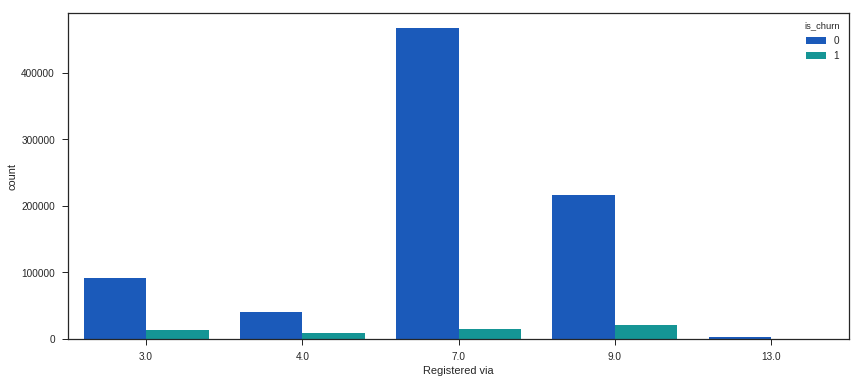

In [35]:
print('Number of unique value',train['registered_via'].unique())
plt.figure(figsize=(14,6))
sns.set_style('ticks')
sns.countplot(train['registered_via'],palette='summer')
plt.xlabel('Registered via')

plt.figure(figsize=(14,6))
sns.set_style('ticks')
sns.countplot(data=train ,x='registered_via',palette='winter',hue='is_churn')
plt.xlabel('Registered via')

# registration_init_time

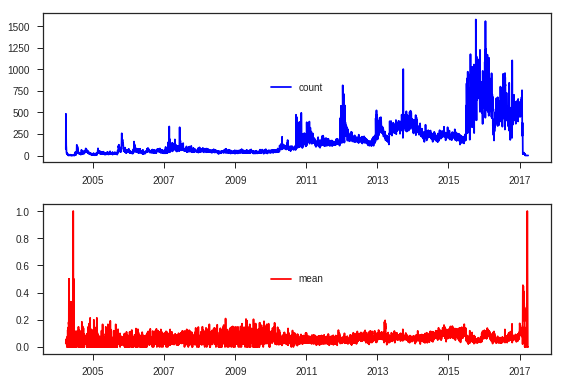

In [39]:
regi = train.groupby('registration_init_time').count()['is_churn']
plt.subplot(211)
plt.plot(regi,color='b',label='count')
plt.legend(loc='center')
regi = train.groupby('registration_init_time').mean()['is_churn']
plt.subplot(212)
plt.plot(regi,color='r',label='mean')
plt.legend(loc='center')
plt.tight_layout()

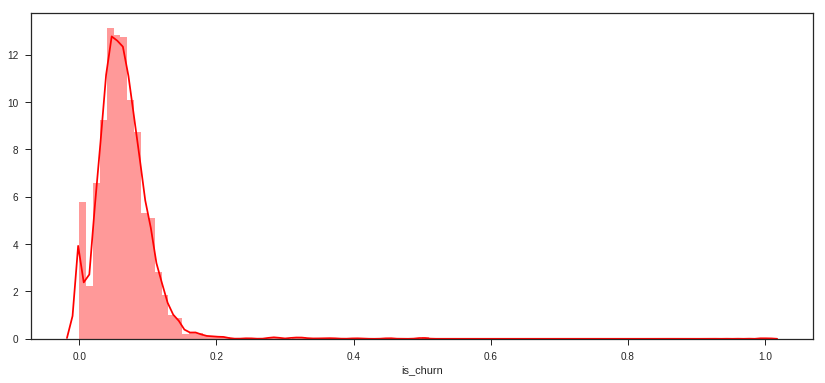

In [195]:
regi = train.groupby('registration_init_time').mean()['is_churn']
plt.figure(figsize=(14,6))
sns.distplot(regi,bins=100,color='r')

# expiration_date

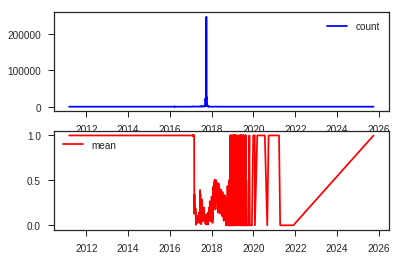

In [9]:
exp = train.groupby('expiration_date').count()['is_churn']
plt.subplot(211)
plt.plot(exp,color='b',label='count')
plt.legend(loc='best')

exp = train.groupby('expiration_date').mean()['is_churn']
plt.subplot(212)
plt.plot(exp,color='r',label='mean')
plt.legend(loc='best')

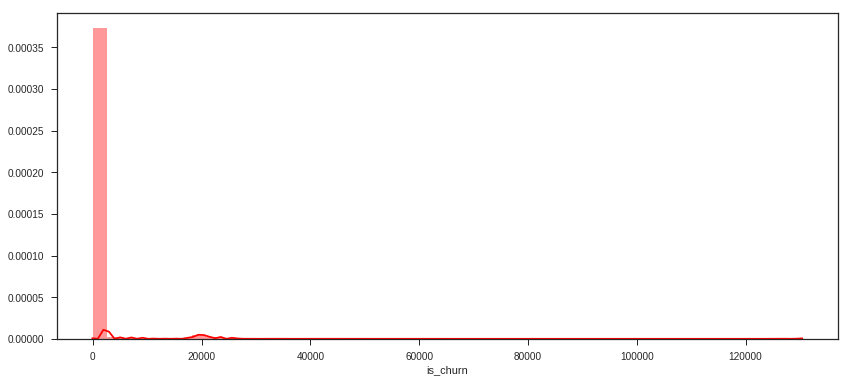

In [12]:
exp = train.groupby('expiration_date').count()['is_churn']
plt.figure(figsize=(14,6))
sns.distplot(exp,color='r',bins=50)

# duration

Number of unique value 5088


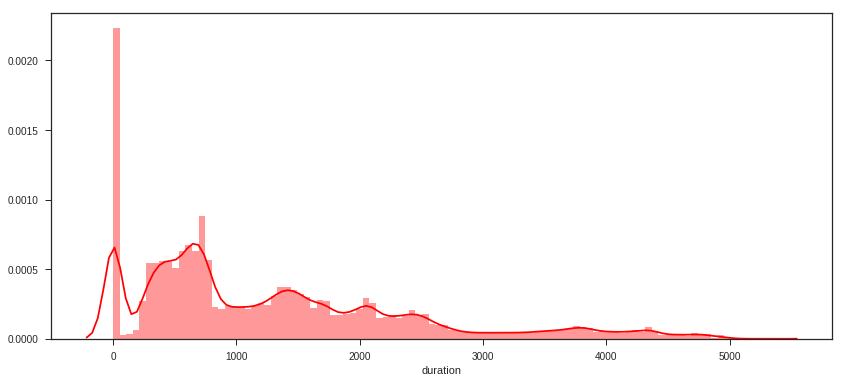

In [16]:
print('Number of unique value',train['duration'].nunique())
plt.figure(figsize=(14,6))
sns.distplot(train['duration'],color='r',bins=100)


# reg_day

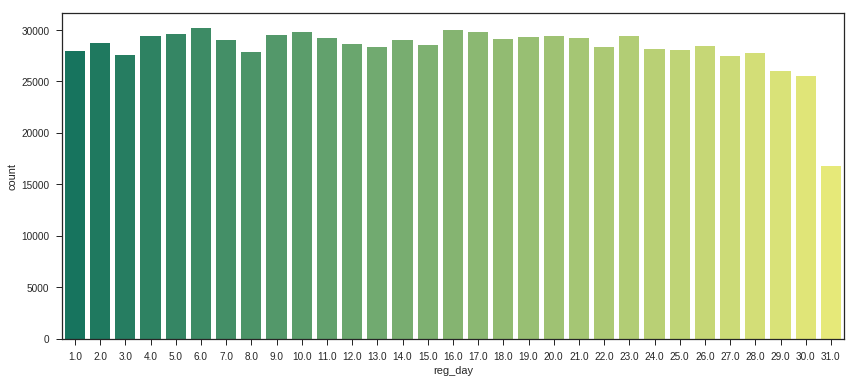

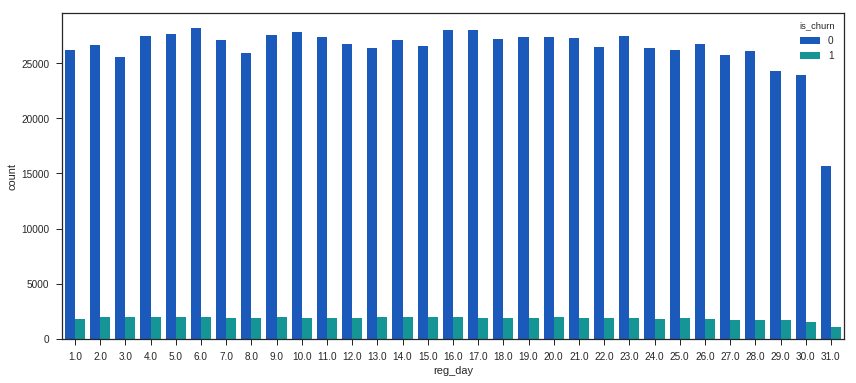

In [34]:
plt.figure(figsize=(14,6))
sns.countplot(train['reg_day'],palette='summer')
plt.figure(figsize=(14,6))
sns.countplot(data=train,x='reg_day',palette='winter',hue='is_churn')


# reg_weekday

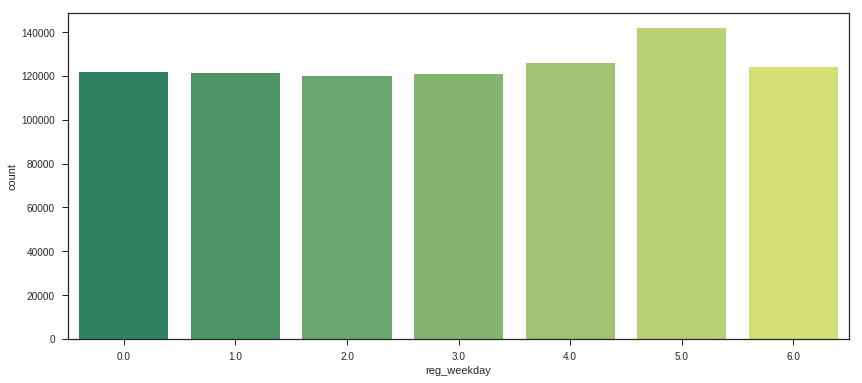

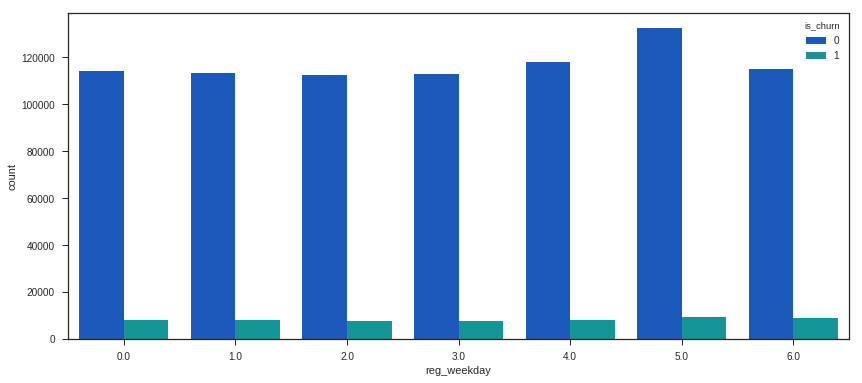

In [33]:
plt.figure(figsize=(14,6))
sns.countplot(train['reg_weekday'],palette='summer')

plt.figure(figsize=(14,6))
sns.countplot(data=train,x='reg_weekday',palette='winter',hue='is_churn')


# reg_month

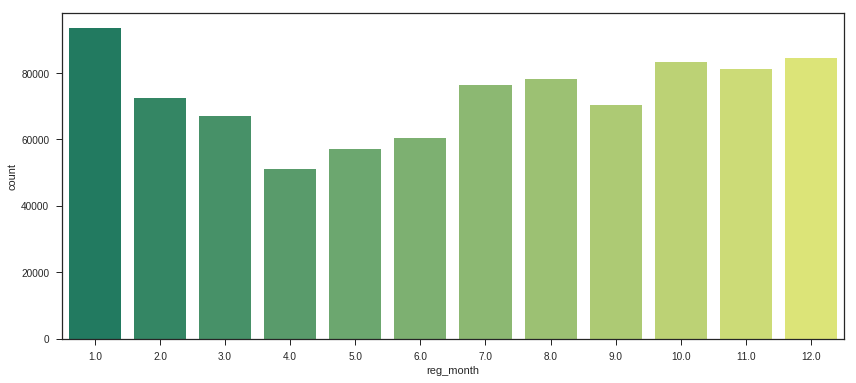

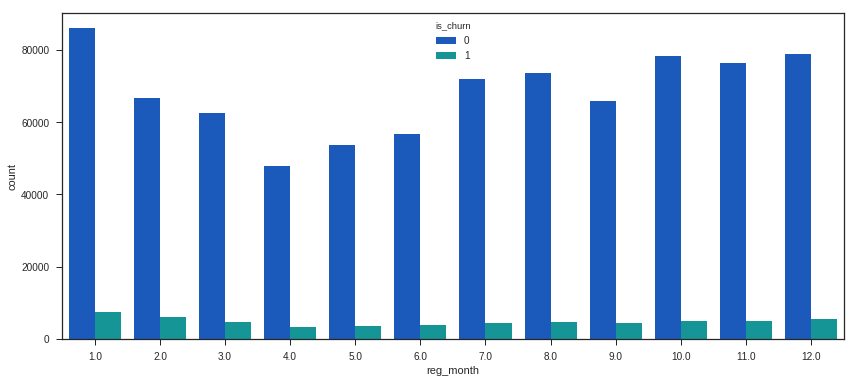

In [48]:
plt.figure(figsize=(14,6))
sns.countplot(train['reg_month'],palette='summer')

plt.figure(figsize=(14,6))
sns.countplot(data=train,x='reg_month',palette='winter',hue='is_churn')

# reg_year

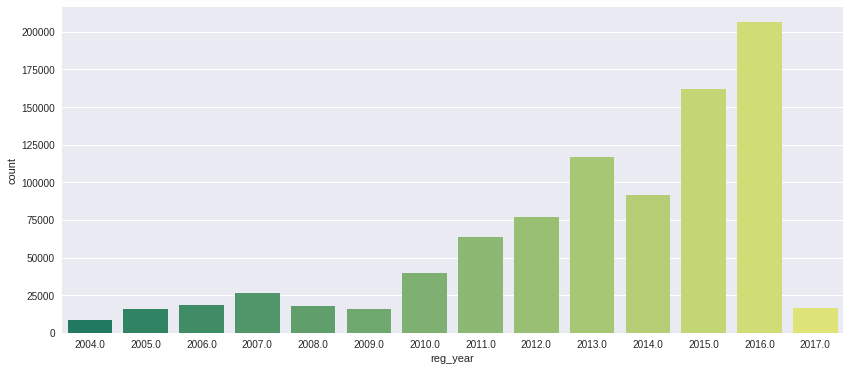

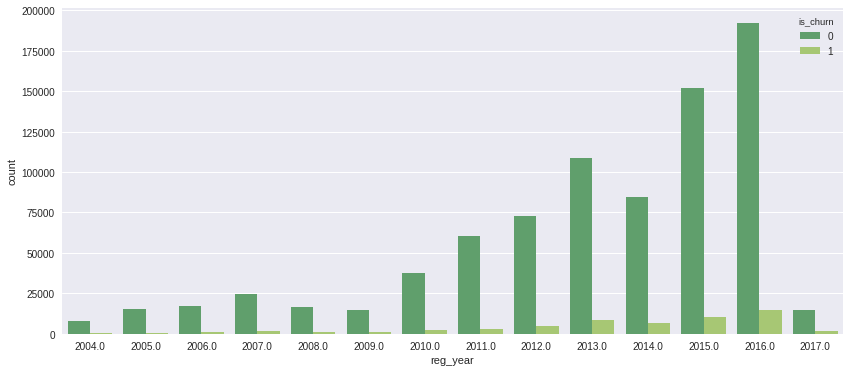

In [14]:
plt.figure(figsize=(14,6))
sns.countplot(data=train,x='reg_year',palette='summer')

plt.figure(figsize=(14,6))
sns.countplot(data=train,x='reg_year',palette='summer',hue='is_churn')

# exp_day

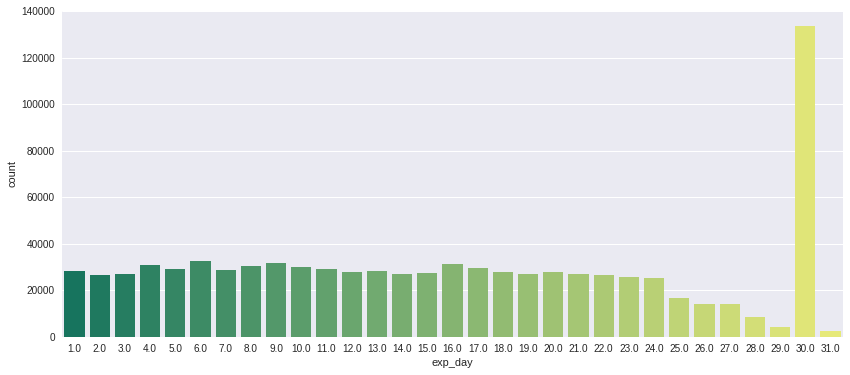

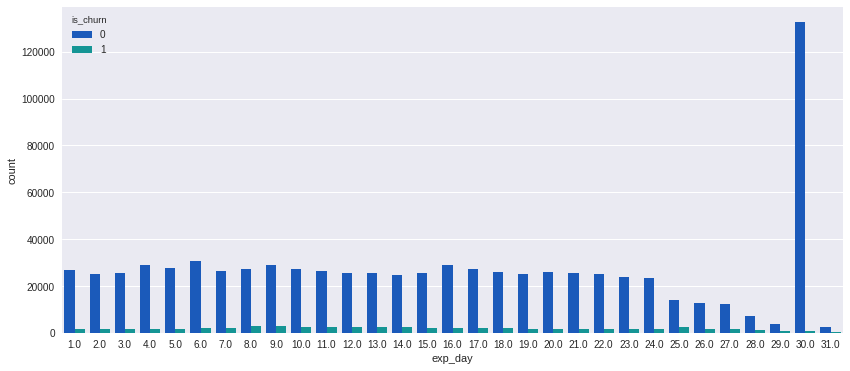

In [16]:
plt.figure(figsize=(14,6))
sns.countplot(data=train,x='exp_day',palette='summer')

plt.figure(figsize=(14,6))
sns.countplot(data=train,x='exp_day',palette='winter',hue='is_churn')

# exp_weekday

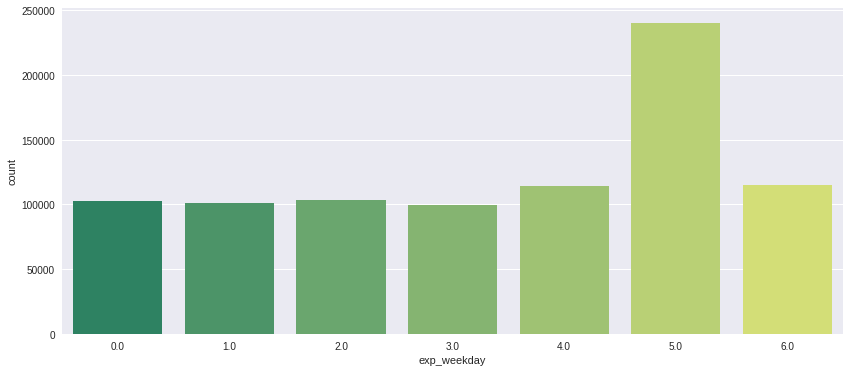

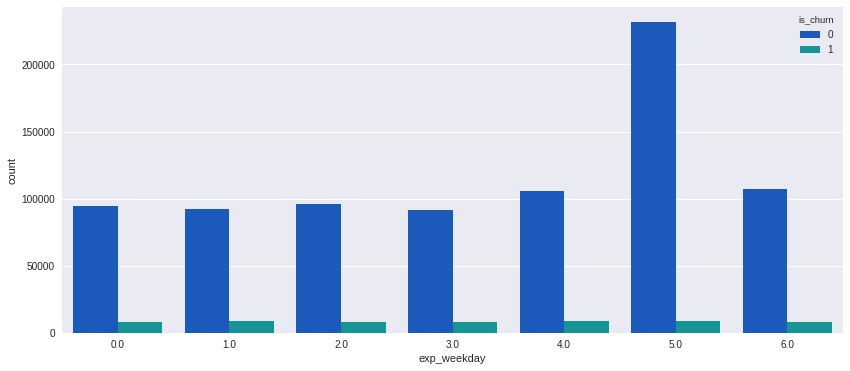

In [17]:
plt.figure(figsize=(14,6))
sns.countplot(data=train,x='exp_weekday',palette='summer')

plt.figure(figsize=(14,6))
sns.countplot(data=train,x='exp_weekday',palette='winter',hue='is_churn')

# exp_month

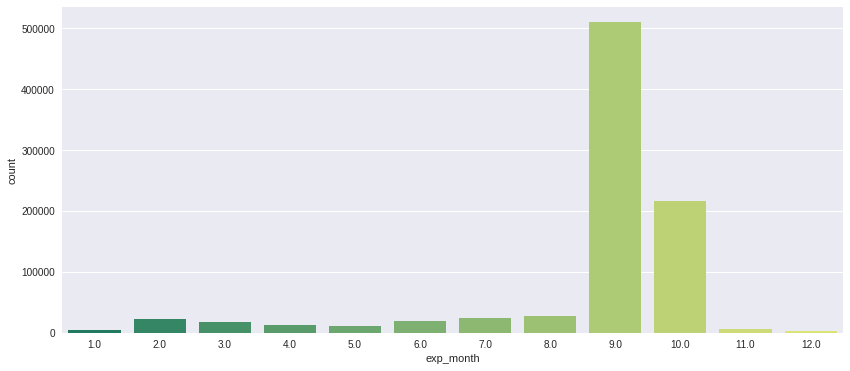

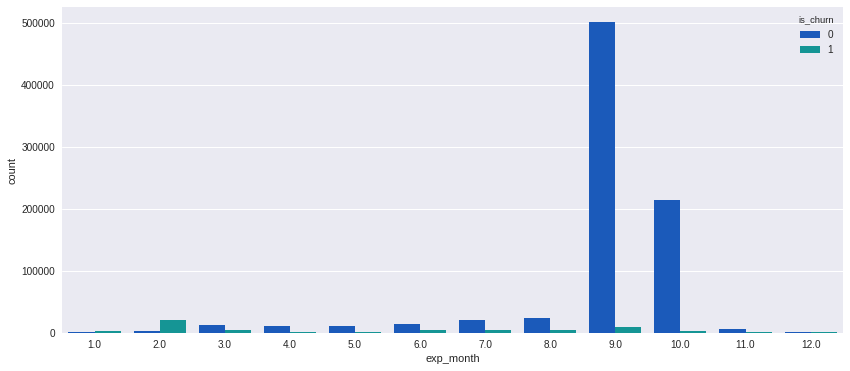

In [23]:
plt.figure(figsize=(14,6))
sns.countplot(data=train,x='exp_month',palette='summer')

plt.figure(figsize=(14,6))
sns.countplot(data=train,x='exp_month',palette='winter',hue='is_churn')

# exp_year

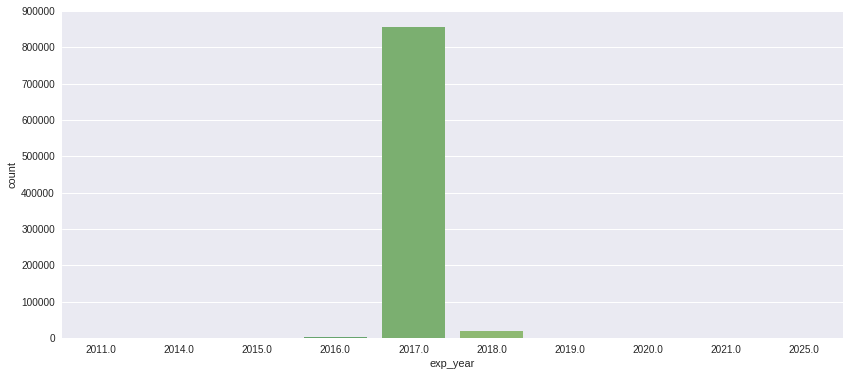

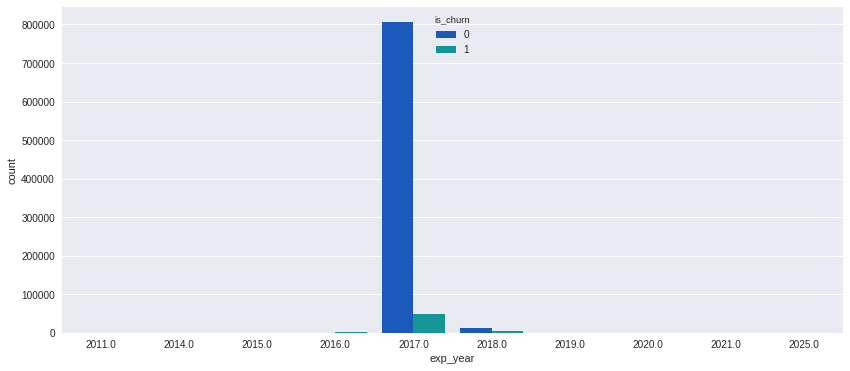

In [24]:
plt.figure(figsize=(14,6))
sns.countplot(data=train,x='exp_year',palette='summer')

plt.figure(figsize=(14,6))
sns.countplot(data=train,x='exp_year',palette='winter',hue='is_churn')

# Bivariate analysis

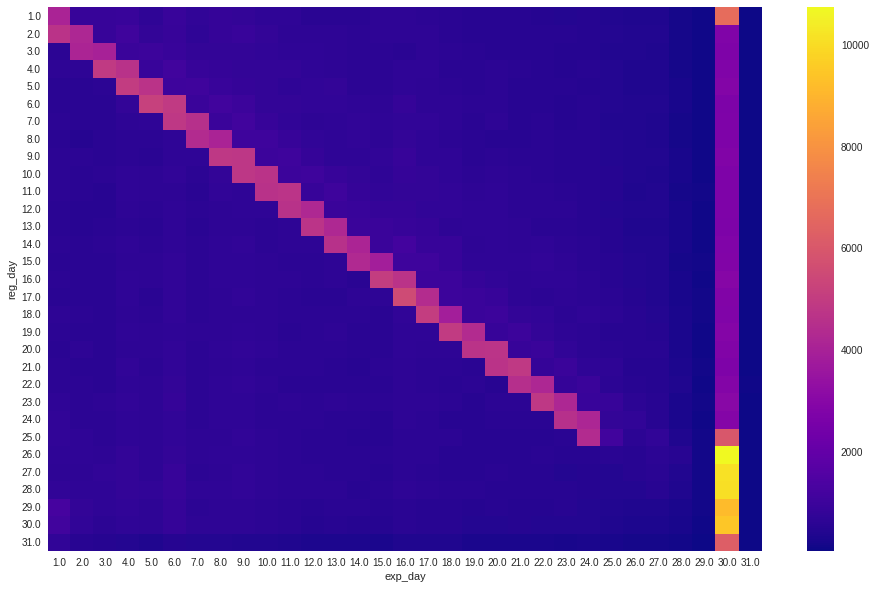

In [48]:
reg_exp = train.groupby(['reg_day','exp_day']).count()['is_churn'].unstack()
plt.figure(figsize=(16,10))
sns.heatmap(reg_exp,cmap='plasma')

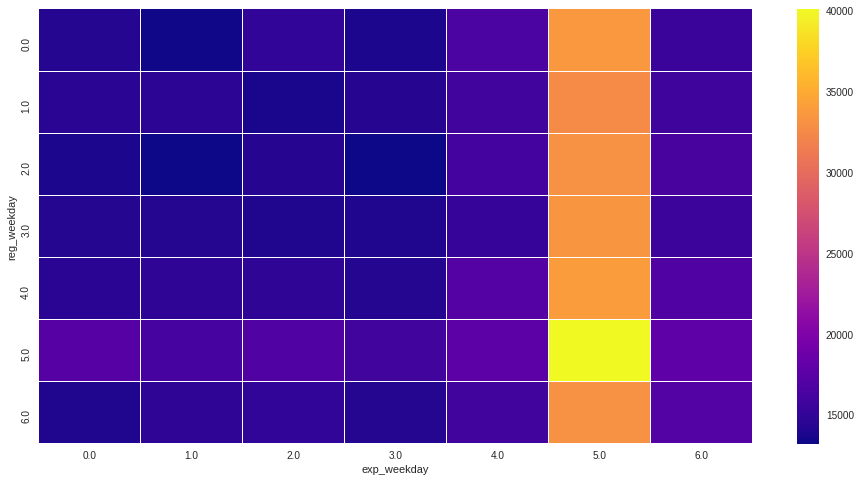

In [46]:
reg_exp = train.groupby(['reg_weekday','exp_weekday']).count()['is_churn'].unstack()

plt.figure(figsize=(16,8))
sns.heatmap(reg_exp,cmap='plasma',linewidths=0.01)

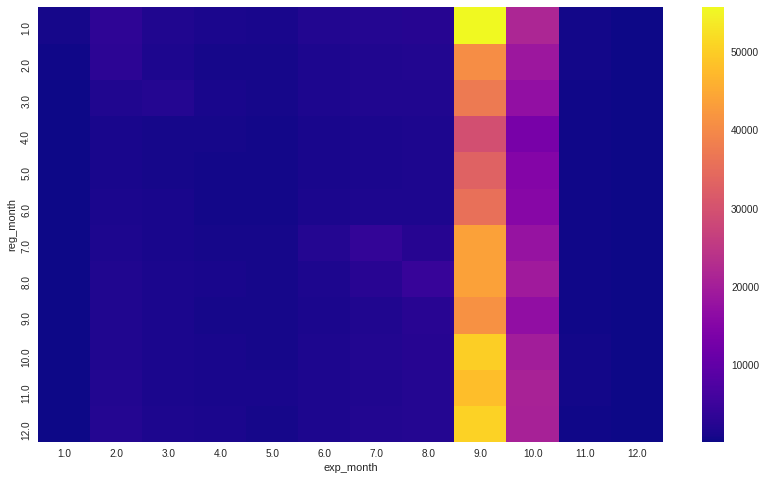

In [7]:
reg_exp = train.groupby(['reg_month','exp_month']).count()['is_churn'].unstack()
plt.figure(figsize=(14,8))
sns.heatmap(reg_exp,cmap='plasma')

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5]),
 <a list of 14 Text yticklabel objects>)

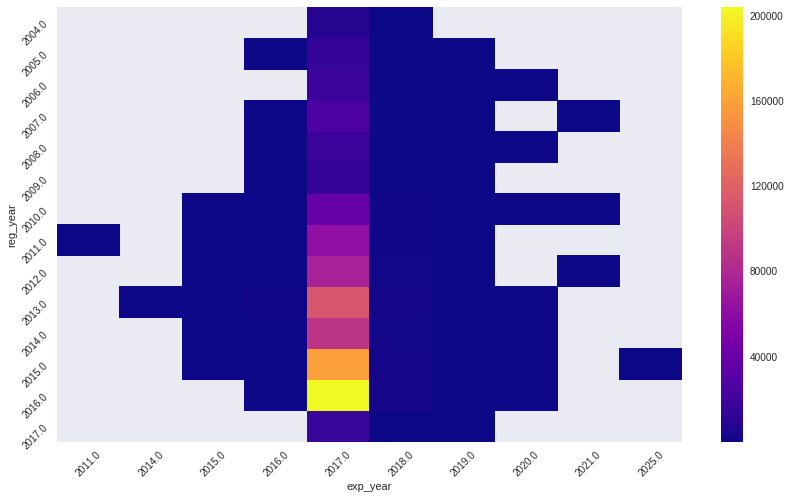

In [55]:
reg_exp = train.groupby(['reg_year','exp_year']).count()['is_churn'].unstack()
plt.figure(figsize=(14,8))
sns.heatmap(reg_exp,cmap='plasma')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5]), <a list of 13 Text xticklabel objects>)

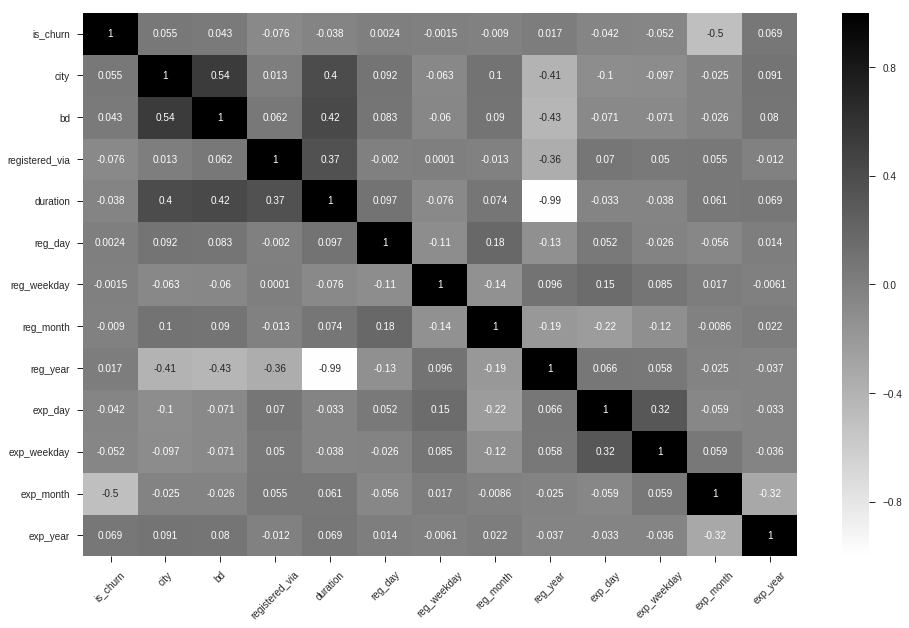

In [60]:
cor = train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor,cmap='binary',annot=True)
plt.xticks(rotation=45)

# Encoder

In [61]:
le = LabelEncoder()
train['gender'] = le.fit_transform(train['gender'])
test['gender'] = le.fit_transform(test['gender'])

In [14]:
def unique(df):
    col = df.columns
    for i in col:
        print("Number of unique value in '{}' variable is {}".format(i,df[i].nunique()))

unique(train)

Number of unique value in 'msno' variable is 992931
Number of unique value in 'is_churn' variable is 2
Number of unique value in 'city' variable is 21
Number of unique value in 'bd' variable is 231
Number of unique value in 'gender' variable is 2
Number of unique value in 'registered_via' variable is 5
Number of unique value in 'registration_init_time' variable is 4724
Number of unique value in 'expiration_date' variable is 1216
Number of unique value in 'duration' variable is 5088
Number of unique value in 'reg_day' variable is 31
Number of unique value in 'reg_weekday' variable is 7
Number of unique value in 'reg_month' variable is 12
Number of unique value in 'reg_year' variable is 14
Number of unique value in 'exp_day' variable is 31
Number of unique value in 'exp_weekday' variable is 7
Number of unique value in 'exp_month' variable is 12
Number of unique value in 'exp_year' variable is 10


# One Hot Encoding

In [15]:
def OHE(df):
    #col = df.select_dtypes(include=['category']).columns
    col = ['city','gender','registered_via']
    print('Categorical columns in dataset',col)
    
    c2,c3 = [],{}
    for c in col:
        if df[c].nunique()>2 :
            c2.append(c)
            c3[c] = 'ohe_'+c
    
    df = pd.get_dummies(df,columns=c2,drop_first=True,prefix=c3)
    print(df.shape)
    return df
train1 = OHE(train)
test1 = OHE(test)

Categorical columns in dataset ['city', 'gender', 'registered_via']
(992931, 39)
Categorical columns in dataset ['city', 'gender', 'registered_via']
(970960, 39)


In [1]:
train1.columns

NameError: name 'train1' is not defined

# Split data set

In [107]:
unwanted = ['msno','is_churn','registration_init_time','expiration_date']

X = train1.drop(unwanted,axis=1)
y = train1['is_churn']
x_test = test1.drop(unwanted,axis=1)


NameError: name 'train1' is not defined

# Logistic regression model with Stratified KFold split

In [19]:
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=seed)
pred_test_full =0
cv_score =[]

for train_index,test_index in kf.split(X,y):
    print('KFold',kf.n_splits)
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    lr =LogisticRegression()
    lr.fit(xtr,ytr)
    cv_score.append(roc_auc_score(yvl,lr.predict(xvl)))
    pred_test = lr.predict_proba(x_test)[:,1]
    pred_test_full +=pred_test

KFold 10
KFold 10
KFold 10
KFold 10
KFold 10
KFold 10
KFold 10
KFold 10
KFold 10
KFold 10


# Model validation

In [20]:
print(cv_score)
print('\nMean accuracy',np.mean(cv_score))
confusion_matrix(yvl,lr.predict(xvl))

[0.68195396969527244, 0.68572988625522058, 0.68999498789905411, 0.68240391235909292, 0.69359722928480405, 0.67906763636287693, 0.67850926508077691, 0.68955651509369464, 0.68723504384334788, 0.68393605966957371]

Mean accuracy 0.685198450554


array([[91846,  1100],
       [ 3937,  2410]])

# Predict for unseen data set

In [21]:
y_pred = pred_test_full/10
submit = pd.DataFrame({'msno':test['msno'],'is_churn':y_pred})
#submit.to_csv('kk_pred.csv',index=False)
submit.to_csv('kk_pred.csv.gz',index=False,compression='gzip')

# XGBoost

In [180]:
def runXGB(xtrain,xvalid,ytrain,yvalid,xtest,eta=0.1,num_rounds=100,max_depth=4):
    params = {
        'objective':'binary:logistic',        
        'max_depth':max_depth,
        'learning_rate':eta,
        'eval_metric':'auc',
        'min_child_weight':1,
        'subsample':0.8,
        'colsample_bytree':0.8,
        'seed':seed,
        'reg_lambda':1
        #'n_thread':-1
    }
    
    dtrain = xgb.DMatrix(xtrain,label=ytrain)
    dvalid = xgb.DMatrix(xvalid,label=yvalid)
    dtest = xgb.DMatrix(xtest)
    watchlist = [(dtrain,'train'),(dvalid,'test')]
    
    model = xgb.train(params,dtrain,num_rounds,watchlist,early_stopping_rounds=20,verbose_eval=20)
    pred = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    pred_test = model.predict(dtest,ntree_limit=model.best_ntree_limit)
    return pred_test,model
    

In [176]:
unwanted = ['msno','is_churn','registration_init_time','expiration_date']

X = train.drop(unwanted,axis=1)
y = train['is_churn']
x_test = test.drop(unwanted,axis=1)

In [181]:
kf = StratifiedKFold(n_splits=3,random_state=seed)
pred_test_full =0
cv_score = []
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    pred_test,xg_model = runXGB(xtr,xvl,ytr,yvl,x_test,num_rounds=500,eta=0.05)    
    pred_test_full += pred_test
    i+=1


1 of KFold 3
[0]	train-auc:0.851453	test-auc:0.851814
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[20]	train-auc:0.915954	test-auc:0.915141
[40]	train-auc:0.921881	test-auc:0.920878
[60]	train-auc:0.92352	test-auc:0.922108
[80]	train-auc:0.92472	test-auc:0.922874
[100]	train-auc:0.925608	test-auc:0.92332
[120]	train-auc:0.926339	test-auc:0.923831
[140]	train-auc:0.926997	test-auc:0.924178
[160]	train-auc:0.927444	test-auc:0.924321
[180]	train-auc:0.927901	test-auc:0.924349
Stopping. Best iteration:
[164]	train-auc:0.927521	test-auc:0.924438

2 of KFold 3
[0]	train-auc:0.853038	test-auc:0.849394
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[20]	train-auc:0.916733	test-auc:0.915843
[40]	train-auc:0.921871	test-auc:0.920886
[60]	train-auc:0.923762	test-auc:0.922614
[80]	train-auc:0.92506	test-auc:0.

# Predict for unseen data set

In [21]:
y_pred = pred_test_full/10
submit = pd.DataFrame({'msno':test['msno'],'is_churn':y_pred})
#submit.to_csv('kk_pred.csv',index=False)
submit.to_csv('kk_pred.csv.gz',index=False,compression='gzip')

# Thank you for visiting